In [580]:
import numpy as np  
import matplotlib.pyplot as plt
import gymnasium as gym
import time
import os
from collections import defaultdict

In [581]:
env = gym.make('CliffWalking-v0')
numactions = env.action_space.n
numstates = env.observation_space.n
print("Number of actions: ", numactions)
print("Number of states: ", numstates)

Number of actions:  4
Number of states:  48


In [582]:
def epsilon_greedy_policy(epsilon,Q,env):
  def policy(state):
    if state not in Q:
      #take any action with equal probability
      return np.random.choice(env.action_space.n)
    else:
      #take the best action with probability 1-epsilon
      if np.random.random() > epsilon:
        return np.argmax(Q[state])
      else:
        return np.random.choice(env.action_space.n)
  return policy

In [ ]:
def sarsa_nstep(env,numeps,epsilon,alpha,gamma,nstep):
  Q = defaultdict(lambda: np.zeros(env.action_space.n))
  
  for i in range(numeps):
    if i % 10000 == 0:
      print("Episode: ", i)
    state, _ = env.reset()
    done = False
    T = float('inf')
    t = 0
    #initalise the policy
    policy = epsilon_greedy_policy(epsilon,Q,env)
    
    #stores state,action,reward tuples
    buffer = []
    
    #initialise the first action
    action = policy(state)
    
    while not done:
      if t < T:
        tup = env.step(action) 
        next_state, reward, terminated, truncated = tup[0], tup[1], tup[2], tup[3]
        done = terminated or truncated
        buffer.append((state,action,reward))
        if done:
          T = t+1
        else:
          state = next_state
          action = policy(state)
          
      tau = t-nstep+1
      
      if tau >= 0:
        G = 0
        j = min(tau+nstep,T)

        for k in range(tau+1, j+1):
          G += (gamma**(k-tau-1))*buffer[k-1][2]

        if tau+nstep < T:
          state_tau_n = buffer[tau+nstep-1][0]
          action_tau_n = buffer[tau+nstep-1][1]
          G = G + (gamma**nstep)*buffer[state_tau_n][action_tau_n]

        state_tau = buffer[tau][0]
        action_tau = buffer[tau][1]
        Q[state_tau][action_tau] += alpha*(G-Q[state_tau][action_tau])        
      t += 1
      
      if tau == T-1:
        break
          
  return Q, policy

In [584]:
numeps = 50000
epsilon = 0.1
alpha = 0.1
nsteps = 4
gamma = 1


In [585]:
Q, policy = sarsa_nstep(env,numeps,epsilon,alpha,gamma,nsteps)

Episode:  0
Episode:  10000
Episode:  20000
Episode:  30000
Episode:  40000


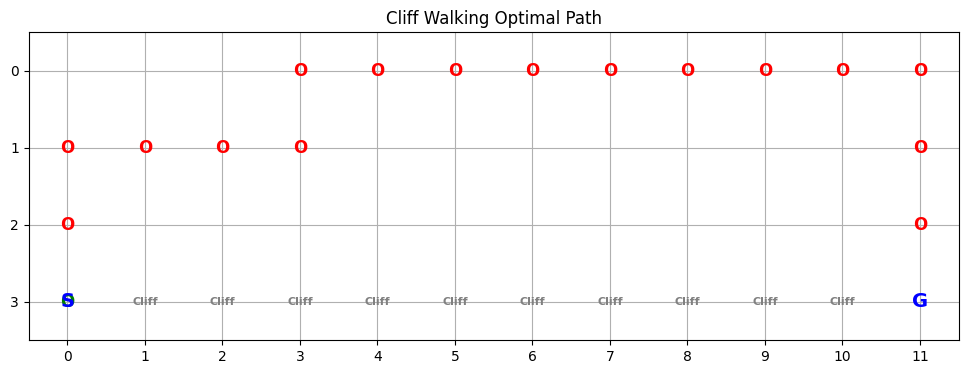

In [587]:
def plot_cliffwalking_paths(Q, env):
    grid_rows, grid_cols = 4, 12  # Grid dimensions for CliffWalking-v0
    start_state = 36  # Start state index
    goal_state = 47   # Goal state index

    # Initialize the grid
    grid = np.zeros((grid_rows, grid_cols), dtype=int)

    # Define the cliff area
    cliff_indices = np.arange(37, 47)
    for idx in cliff_indices:
        row, col = divmod(idx, grid_cols)
        grid[row, col] = -100  # Cliff cells

    # Compute the optimal path
    state, _ = env.reset()
    optimal_path = []
    done = False
    while not done:
        row, col = divmod(state, grid_cols)
        optimal_path.append((row, col))
        action = np.argmax(Q[state]) 
        tup = env.step(action)
        state, _, done, _ = tup if len(tup) == 4 else (tup[0], tup[1], tup[2], None)

    # Mark the start and goal positions
    start_row, start_col = divmod(start_state, grid_cols)
    goal_row, goal_col = divmod(goal_state, grid_cols)

    # Plot the grid
    plt.figure(figsize=(12, 4))
    for r in range(grid_rows):
        for c in range(grid_cols):
            if (r, c) in optimal_path:
                color = "red" if (r, c) != (start_row, start_col) and (r, c) != (goal_row, goal_col) else "green"
                plt.text(c, r, 'O', ha='center', va='center', color=color, fontsize=12, fontweight='bold')
            elif grid[r, c] == -100:
                plt.text(c, r, 'Cliff', ha='center', va='center', color='gray', fontsize=8, fontweight='bold')

    # Highlight start and goal
    plt.text(start_col, start_row, 'S', ha='center', va='center', color='blue', fontsize=14, fontweight='bold')
    plt.text(goal_col, goal_row, 'G', ha='center', va='center', color='blue', fontsize=14, fontweight='bold')

    # Draw the grid
    plt.xlim(-0.5, grid_cols - 0.5)
    plt.ylim(grid_rows - 0.5, -0.5)
    plt.xticks(range(grid_cols))
    plt.yticks(range(grid_rows))
    plt.grid(True)
    plt.title("Cliff Walking Optimal Path")
    plt.show()

# Plot the optimal path
plot_cliffwalking_paths(Q, env)
